# §5 統計モデル

#### Packageの読み込み

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.statespace.sarimax import auto_arima
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

import datetime as dt
import math
import itertools
import warnings

#### Dataの読み込み（セクション2のまとめ）

In [2]:
df1 = pd.read_csv("./csv/japan/newly_confirmed_cases_daily.csv")

# Indexを変更し日付型に変換
df2 = df1.set_index("Date")
df2.index = pd.to_datetime(df2.index)

# ①原系列の定義
df3 = df2[(df2.index >= '2020-05-01') & (df2.index <= '2023-04-30')]
df = df3[["ALL"]].copy()
df.rename(columns={"ALL": "original"}, inplace = True)

#### その他の変数の定義（セクション3のまとめ）
(セクション4のまとめなし)

In [3]:
# ②移動平均の定義
df["MA"] = df["original"].rolling(window=7,min_periods=1).mean()

# ③対数系列の定義
c = 1e-5#ゼロを含むため極小さな値を入れる
df["log"] = np.log(df["original"]+c)

# ④一次差分系列の定義
df['1day_diff'] = df["original"].diff(1)

# ⑤季節階差（週トレンド）の定義
df['7day_diff'] =df ["original"].diff(7)

# ⑥対数1次差分系列
df["log_1day_diff"] = df["log"].diff(1) 

# ⑦対数7次差分系列
df["log_7day_diff"] = df["log"].diff(7)

# 欠損値の確認
df.head()
print(df.isna().sum())

original         0
MA               0
log              0
1day_diff        1
7day_diff        7
log_1day_diff    1
log_7day_diff    7
dtype: int64


#### 学習データと検証データを分割
ARMA-ARIMA-SARIMAは単変量モデルであることに注意

In [4]:
train_df = df["original"]["2022-01-01":"2022-03-14"]
test_df = df["original"]["2022-03-15":"2022-03-31"]

### ①ARMA(p,q)モデル

In [5]:
from statsmodels.tsa.arima.model import ARIMA

#### パラメータの定義（ARMAをベースラインとする）

In [6]:
p = 1  # 自己回帰項の次数
d = 0  # 差分の次数
q = 1  # 移動平均項の次数

#### モデルの学習

In [7]:
model_arima = ARIMA(train_df, order=(p, d, q))
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:               original   No. Observations:                   73
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -793.197
Date:                Sat, 16 Dec 2023   AIC                           1594.394
Time:                        10:31:29   BIC                           1603.556
Sample:                    01-01-2022   HQIC                          1598.045
                         - 03-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.539e+04   1.84e+04      3.011      0.003    1.93e+04    9.14e+04
ar.L1          0.9626      0.035     27.902      0.000       0.895       1.030
ma.L1         -0.2903      0.104     -2.787      0.0

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#### モデルによる予測

In [8]:
start_date = test_df.index[0]# 予測開始日
end_date = test_df.index[-1]# 予測終了日

# 予測実行
pred = results_arima.predict(start=start_date, end=end_date)
pred.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 17 entries, 2022-03-15 to 2022-03-31
Freq: D
Series name: predicted_mean
Non-Null Count  Dtype  
--------------  -----  
17 non-null     float64
dtypes: float64(1)
memory usage: 272.0 bytes


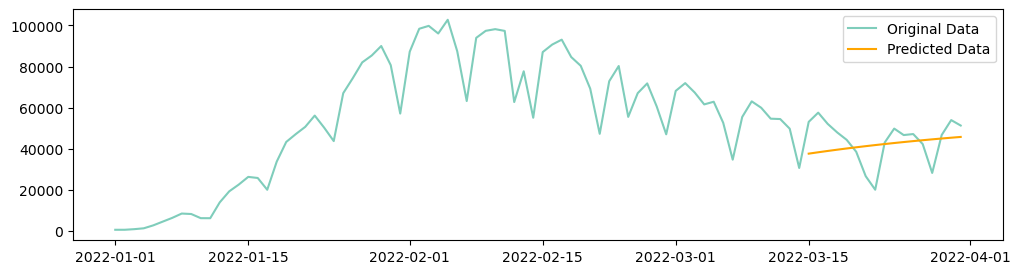

In [9]:
actual = df["original"]["2022-01-01":"2022-03-31"]

plt.figure(figsize=(12,3))
plt.plot(actual, color='#7FCDBB', label='Original Data')
plt.plot(pred.index, pred, color='orange', label='Predicted Data')

plt.legend()
plt.savefig("./image/arma1.jpeg", dpi=300)
plt.show()

#### 精度評価

In [10]:
# 元のスケールに戻すために指数関数を適用
y_true = test_df
y_pred = pred

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 評価指標をデータフレームに格納
metrics_df = pd.DataFrame({'ARMA': [rmse, mse, mae, mape]},
                          index=['RMSE', 'MSE', 'MAE', 'MAPE'])

metrics_df

,ARMA
RMSE,1.089739e+04
MSE,1.187531e+08
MAE,8.695853e+03
MAPE,2.401799e+01


#### モデル診断

In [11]:
model_arima = ARIMA(train_df, order=(p, d, q))
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:               original   No. Observations:                   73
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -793.197
Date:                Sat, 16 Dec 2023   AIC                           1594.394
Time:                        10:31:33   BIC                           1603.556
Sample:                    01-01-2022   HQIC                          1598.045
                         - 03-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.539e+04   1.84e+04      3.011      0.003    1.93e+04    9.14e+04
ar.L1          0.9626      0.035     27.902      0.000       0.895       1.030
ma.L1         -0.2903      0.104     -2.787      0.0

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#### 検定結果
Ljung-Box検定およびJarque-Bera検定の結果, p値(prob)は0.05以上であり, 帰無仮説は棄却しない.

### ②ARIMA(p,d,q)モデル

#### パラメータのグリッドサーチとAICを検証して最良モデルを選択する
（Ljung-Box検定およびJarque-Bera検定も含める.）

In [12]:
# パラメータ範囲を定義
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)

In [13]:
def arima_grid_search(data, p_values, d_values, q_values):
    best_aic = float("inf")
    best_order = None
    best_model = None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            temp_model = ARIMA(data, order=(p, d, q))
            results = temp_model.fit()

            # Ljung-Boxテスト（Prob(Q)）とJarque-Beraテスト（Prob(JB)）の結果を取得
            ljung_box = acorr_ljungbox(results.resid, lags=[1], return_df=True)
            jarque_bera_test = jarque_bera(results.resid)

            # 両方のp値が0.05以上の場合にのみAICを比較
            if ljung_box['lb_pvalue'].iloc[0] >= 0.05 and jarque_bera_test[1] >= 0.05:
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
                    best_model = results
        except:
            continue

    if best_order:
        print(f'最適なパラメータ: p={best_order[0]}, d={best_order[1]}, q={best_order[2]}')
        print(f'最適なAIC: {best_aic}')
    else:
        print("適切なモデルが見つかりませんでした。")
    return best_model

# 警告を非表示にする
warnings.filterwarnings("ignore")

# グリッドサーチの実行
best_arima_model = arima_grid_search(train_df, p_values, d_values, q_values)

最適なパラメータ: p=2, d=1, q=4
最適なAIC: 1565.0653803687069


#### モデル診断

In [14]:
print(best_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:               original   No. Observations:                   73
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -775.533
Date:                Sat, 16 Dec 2023   AIC                           1565.065
Time:                        10:31:40   BIC                           1581.002
Sample:                    01-01-2022   HQIC                          1571.410
                         - 03-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4404      0.232      1.895      0.058      -0.015       0.896
ar.L2         -0.5097      0.298     -1.711      0.087      -1.093       0.074
ma.L1         -0.7527      0.270     -2.791      0.0

#### 検定結果（予めてfor文で限定している）
Ljung-Box検定およびJarque-Bera検定の結果, p値(prob)は0.05以上であり, 帰無仮説は棄却しない.

#### 原系列にプロットして当てはまりを確認する

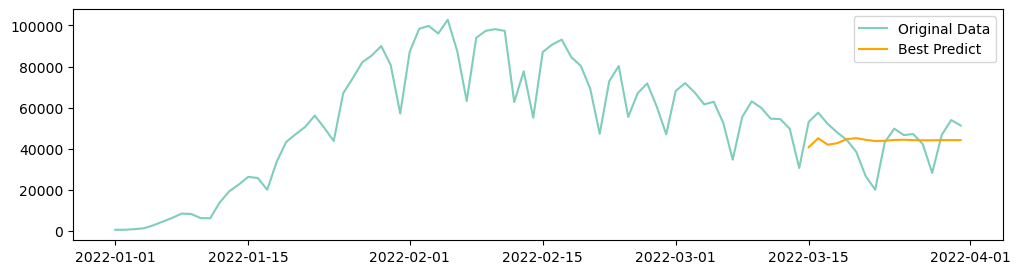

In [15]:
best_pred = best_arima_model.predict(start=start_date, end=end_date)

#対数変換しているので、原系列に戻す
actual = df["original"]["2022-01-01":"2022-03-31"]

plt.figure(figsize=(12,3))
plt.plot(actual, color='#7FCDBB', label='Original Data')
plt.plot(best_pred.index, best_pred, color='orange', label='Best Predict')

plt.legend()
plt.savefig("./image/arima1.jpeg", dpi=300)
plt.show()

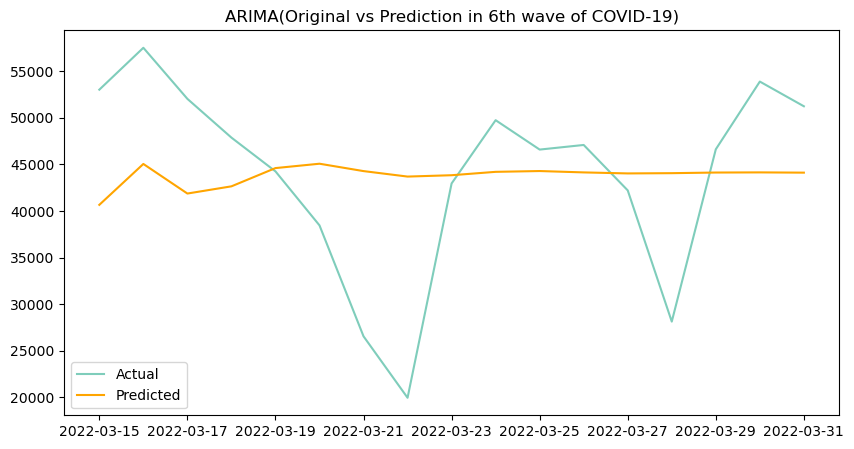

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(test_df, label='Actual', color='#7FCDBB')
plt.plot(best_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted')
plt.title('ARIMA(Original vs Prediction in 6th wave of COVID-19)')
plt.legend()
plt.savefig("./image/arima2.jpeg", dpi=300)
plt.show()

In [17]:
# 元のスケールに戻すために指数関数を適用
y_true = test_df
y_pred = best_pred

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 評価指標をデータフレームに格納
metrics_df["ARIMA"] = pd.DataFrame(
    {"ARIMA": [rmse, mse, mae, mape]},#★
    index=['RMSE', 'MSE', 'MAE', 'MAPE'])

metrics_df

,ARMA,ARIMA
RMSE,1.089739e+04,1.033036e+04
MSE,1.187531e+08,1.067164e+08
MAE,8.695853e+03,8.082938e+03
MAPE,2.401799e+01,2.362586e+01


### ③SARIMA(P,D,Q)(p,d,q)sモデル

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [19]:
# パラメータ範囲を定義
P_values = range(0, 5)
D_values = range(0, 2)
Q_values = range(0, 5)
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
s_values = [7,14]

#### 関数を定義する

In [33]:
def sarima_grid_search(data, P_values, D_values, Q_values, p_values, d_values, q_values, s_values):
    models_aic = []

    for P, D, Q, p, d, q, s in itertools.product(P_values, D_values, Q_values, p_values, d_values, q_values, s_values):
        try:
            temp_model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, s))
            results = temp_model.fit(disp=0)

            ljung_box = acorr_ljungbox(results.resid, lags=[1], return_df=True)
            jarque_bera_test = jarque_bera(results.resid)

            if ljung_box['lb_pvalue'].iloc[0] >= 0.05 and jarque_bera_test[1] >= 0.05:
                models_aic.append((results.aic, (p, d, q), (P, D, Q, s), results))
        except:
            continue

    # AIC でソート
    models_aic.sort(key=lambda x: x[0])

    # ソートされた結果を返す
    return models_aic

best_models = sarima_grid_search(train_df, P_values, D_values, Q_values, p_values, d_values, q_values, s_values)

# 最初の数モデルの AIC とパラメータを表示
for model_info in best_models[:5]:
    print(f'AIC: {model_info[0]}, Order: {model_info[1]}, Seasonal Order: {model_info[2]}')

AIC: 1245.5099020628268, Order: (4, 2, 0), Seasonal Order: (0, 1, 1, 14)
AIC: 1246.6675490264158, Order: (4, 2, 0), Seasonal Order: (1, 1, 0, 14)
AIC: 1250.6015675671435, Order: (4, 2, 0), Seasonal Order: (4, 1, 0, 14)
AIC: 1251.3479695082058, Order: (2, 2, 0), Seasonal Order: (0, 1, 1, 14)
AIC: 1252.2356311528122, Order: (2, 2, 0), Seasonal Order: (1, 1, 0, 14)


In [36]:
# リストをデータフレームに変換
df_models = pd.DataFrame(best_models, columns=['AIC', 'Params', 'Seasonal_Params', 'Model'])

# 最初の5行を表示
print(df_models.head(20))
# df は書き出したいデータフレームを指します。
df_models.to_csv('./csv/output_sarima.csv', index=False)


            AIC     Params Seasonal_Params  \
0   1245.509902  (4, 2, 0)   (0, 1, 1, 14)   
1   1246.667549  (4, 2, 0)   (1, 1, 0, 14)   
2   1250.601568  (4, 2, 0)   (4, 1, 0, 14)   
3   1251.347970  (2, 2, 0)   (0, 1, 1, 14)   
4   1252.235631  (2, 2, 0)   (1, 1, 0, 14)   
5   1252.600781  (4, 2, 0)   (4, 1, 1, 14)   
6   1253.797249  (2, 2, 0)   (2, 1, 0, 14)   
7   1254.600762  (4, 2, 0)   (4, 1, 2, 14)   
8   1254.942568  (2, 2, 0)   (0, 1, 3, 14)   
9   1254.947397  (2, 2, 0)   (3, 1, 0, 14)   
10  1255.167568  (2, 2, 0)   (2, 1, 1, 14)   
11  1256.601388  (4, 2, 0)   (4, 1, 3, 14)   
12  1256.719902  (2, 2, 0)   (4, 1, 0, 14)   
13  1256.779552  (2, 2, 0)   (3, 1, 1, 14)   
14  1256.795737  (2, 2, 0)   (0, 1, 4, 14)   
15  1256.848331  (2, 2, 0)   (1, 1, 3, 14)   
16  1256.938854  (2, 2, 0)   (2, 1, 2, 14)   
17  1258.600764  (4, 2, 0)   (4, 1, 4, 14)   
18  1258.718197  (2, 2, 0)   (4, 1, 1, 14)   
19  1258.742139  (2, 2, 0)   (3, 1, 2, 14)   

                                 

#### CSVから保存されたモデルを順に読み出す
（パラメータサーチに時間がかかるので）

In [28]:
# CSV ファイルからデータを読み込む
df_models_loaded = pd.read_csv('./csv/output_sarima.csv')

# 最良のモデルのパラメータを取得
best_model_info = df_models_loaded.iloc[1]#ここの数字を変えるとリストから任意の行を取得できる
params = eval(best_model_info['Params'])
seasonal_params = eval(best_model_info['Seasonal_Params'])

#### モデル診断

In [29]:
# 新たに SARIMAX モデルを作成し、フィットさせる
sarima_model = SARIMAX(train_df, order=params, seasonal_order=seasonal_params)
fitted_sarima_model = sarima_model.fit()

# モデルのサマリーを表示
print(fitted_sarima_model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46240D+00    |proj g|=  7.43885D-02

At iterate    5    f=  8.45663D+00    |proj g|=  4.16446D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6      8      1     0     0   8.682D-06   8.457D+00
  F =   8.4566270481261352     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                           

 This problem is unconstrained.


#### 検定結果
Ljung-Box検定およびJarque-Bera検定の結果, p値(prob)は0.05以上であり, 帰無仮説は棄却しない.

#### ベストモデルによる予測
試したところ、ベースラインとベストモデルは一致したのでベストモデルのみ掲載

In [30]:
# 予測期間の設定
start_date = test_df.index[0]  # 予測開始日
end_date = test_df.index[-1]   # 予測終了日

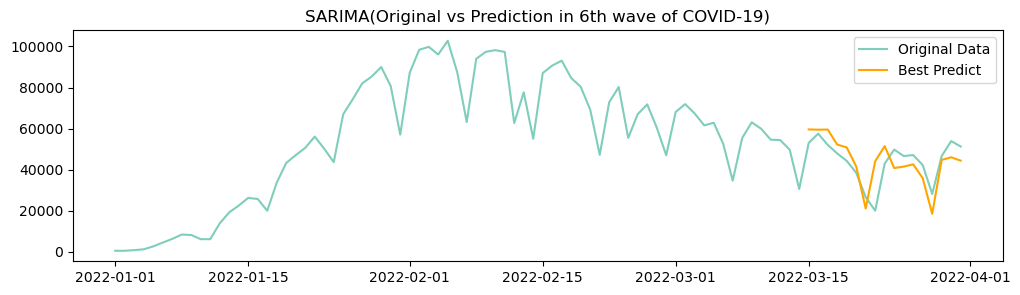

In [31]:
pred = fitted_sarima_model.predict(start=start_date, end=end_date)

actual = df["original"]["2022-01-01":"2022-03-31"]

plt.figure(figsize=(12,3))
plt.plot(actual, color='#7FCDBB', label='Original Data')
plt.plot(pred.index, pred, color='orange', label='Best Predict')
plt.title('SARIMA(Original vs Prediction in 6th wave of COVID-19)')
plt.legend()
plt.savefig("./image/sarima1.jpeg", dpi=300)
plt.show()

#### 拡大ver

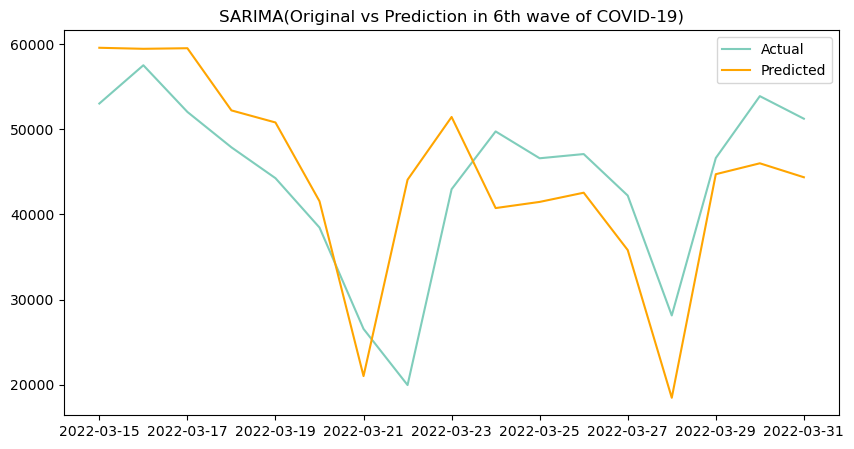

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(test_df, label='Actual', color='#7FCDBB')
plt.plot(pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted')
plt.title('SARIMA(Original vs Prediction in 6th wave of COVID-19)')
plt.legend()
plt.savefig("./image/sarima2.jpeg", dpi=300)
plt.show()

In [33]:
y_true = test_df
y_pred = pred

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

# 評価指標をデータフレームに格納
metrics_df["SARIMA"] = pd.DataFrame(
    {"SARIMA": [rmse, mse, mae, mape]},#★
    index=['RMSE', 'MSE', 'MAE', 'MAPE'])

metrics_df

,ARMA,ARIMA,SARIMA
RMSE,1.089739e+04,1.033036e+04,8.516139e+03
MSE,1.187531e+08,1.067164e+08,7.252462e+07
MAE,8.695853e+03,8.082938e+03,7.026428e+03
MAPE,2.401799e+01,2.362586e+01,2.021605e+01
